# Семинар 7-8: Классификация

В прошлый раз мы говорили про регрессию: мы пытались по выборке предсказать значение непрерывной переменной, количество лайков под постом. В этот раз мы поговорим про задачу классификации. __Вы же ещё не забыли чем отличаются друг от друга эти задачи?__ 

In [34]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами

import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

# 1. Данные и пропуски 

На одном из предыдущих семинаров мы строили с вами визуализации для датасета с данными с youtube по музыкальным клипам. Сегодня мы продолжим с ним работать и попробуем предсказывать жарн видео по его параметрам. 

In [35]:
data = pd.read_csv('../data/youtube_data.csv', sep = '\t')
data.head()

,title,caption,categoryId,commentCount,definition,description,dislikeCount,duration,license,licensedContent,...,comment_mean_len_symbol,comment_mean_len_word,comment_negative_mean_prob,comment_negative_share,commentators_uniq,comments_emoji_max,comments_emoji_mean,comments_emoji_share,comments_obscene_cnt,words_obscene_cnt
0,"""#2Маши ""Свободные линии""",False,10,34.0,hd,ITUNES - https://itun.es/ru/0YzI_,43.0,PT3M30S,youtube,True,...,59.440000,8.840000,0.635410,0.480000,24.0,9.0,1.000000,0.320000,0.0,0.0
1,"""ALARM"" СЕРГЕЙ ЛАЗАРЕВ ( SERGEY LAZAREV )",False,10,NaN,sd,NEW OFFICIAL VIDEO\r\n2010,690.0,PT3M42S,youtube,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""EARTH SONG"" SERGEY LAZAREV. DEDICATED TO MIC...",False,10,26.0,sd,Посвящается Майклу Джексону...\r\nCover-versio...,10.0,PT5M46S,youtube,False,...,120.000000,19.291667,0.725987,0.750000,23.0,13.0,0.666667,0.125000,0.0,0.0
3,"""Earth song"" премия МУЗ-тВ 2010 (LIVE)",False,10,12.0,sd,"Сергей Лазарев, La Toya Jackson, Ани Лорак, Т...",7.0,PT6M16S,youtube,False,...,81.818182,11.545455,0.736776,0.727273,11.0,13.0,1.181818,0.090909,0.0,0.0
4,"""FAKE"" СЕРГЕЙ ЛАЗАРЕВ (SERGEY)",False,10,46.0,sd,official video,19.0,PT3M,youtube,True,...,43.735294,8.617647,0.596008,0.441176,33.0,23.0,0.794118,0.088235,1.0,1.0


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19124 entries, 0 to 19123
Data columns (total 30 columns):
title                         19124 non-null object
caption                       19124 non-null bool
categoryId                    19124 non-null int64
commentCount                  18914 non-null float64
definition                    19124 non-null object
description                   18339 non-null object
dislikeCount                  18850 non-null float64
duration                      19124 non-null object
license                       19124 non-null object
licensedContent               19124 non-null bool
likeCount                     18850 non-null float64
music_style                   19124 non-null object
performer                     19124 non-null object
publicStatsViewable           19124 non-null bool
publishedAt                   19124 non-null object
tags                          17806 non-null object
video_id                      19124 non-null object
viewCount  

Можно заметить, что некоторые данные у нас отсутствуют. Давайте посмотрим на заполненность нашей таблички на картинкею 

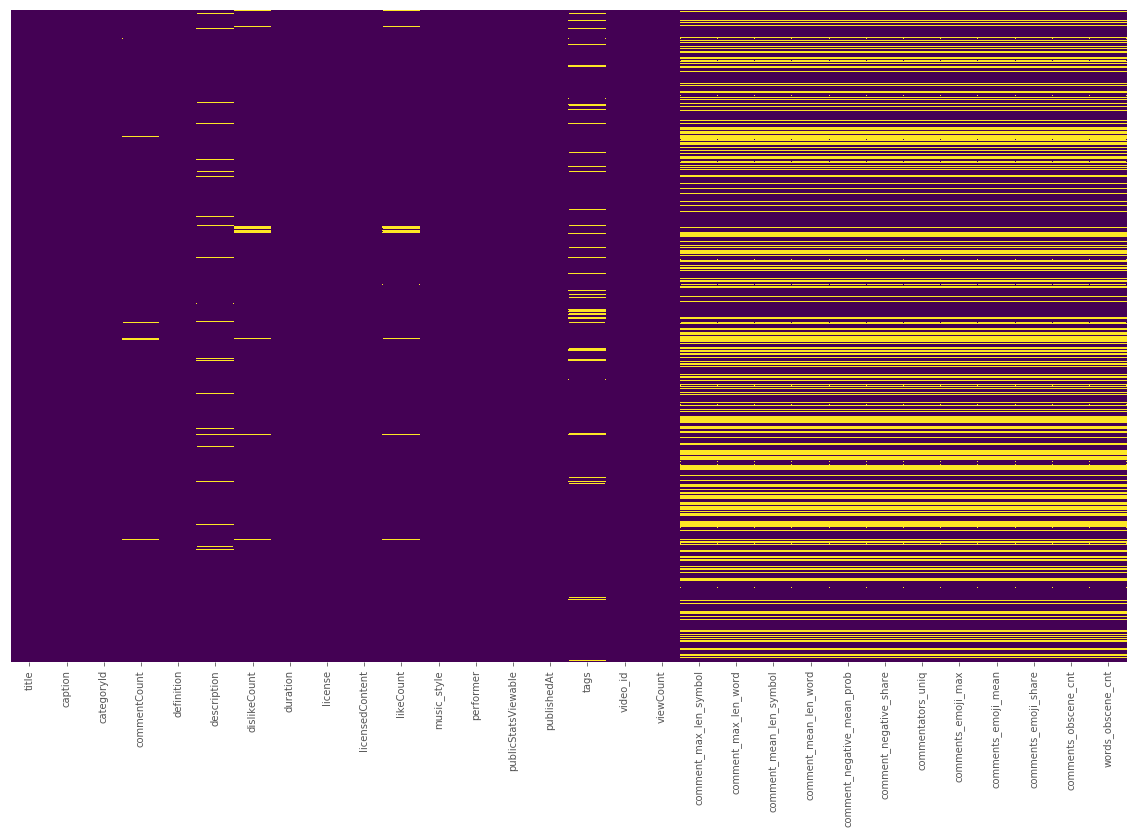

In [37]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Что мы говорим пропускам в данных? Не сегодня. С пропусками нужно бороться. Алгоритмы оцениваются на числах и не любят пропуски (некоторые настроены к пропускам нейтрально, так как умеют их обрабатывать). 

Первое решение: выбросить все наблюдения с пропусками. Проблема такого подхода в том, что другие то переменные для этих наблюдений не пропущены. Значит, выбросив строчки, соответствующие пропускам, мы потеряем кучу информации. Полезной информации. Информацию и без всех наших преобразований легко потерять, сложно найти и невозможно забыть, а мы её ещё и выкинуть хотим. 

Обычно, если пропусков в переменной не очень много, их заполняют чем-нибудь нейтральным. Например, средними или медианами. Когда алгоритм будет натыкаться на них, он будет думать: "Хммм, ну тут ничего особенного, всё как в среднем по выборке, пойду посмотрю другую переменную". И тогда всё будет хорошо. 

Для удобства создаём список из непрерывных переменных. 

In [38]:
real_variables = ["commentCount","dislikeCount","likeCount","viewCount","comment_max_len_symbol",
                 "comment_max_len_word","comment_mean_len_symbol","comment_mean_len_word",
                 "comment_negative_mean_prob","comment_negative_share","commentators_uniq","comments_emoji_max",
                 "comments_emoji_mean","comments_emoji_share","comments_obscene_cnt","words_obscene_cnt"]

Давайте заполним во всех непрерывных переменных пропуски средними. 

In [39]:
for column in real_variables:
    data[column] = data[column].fillna(data[column].mean())

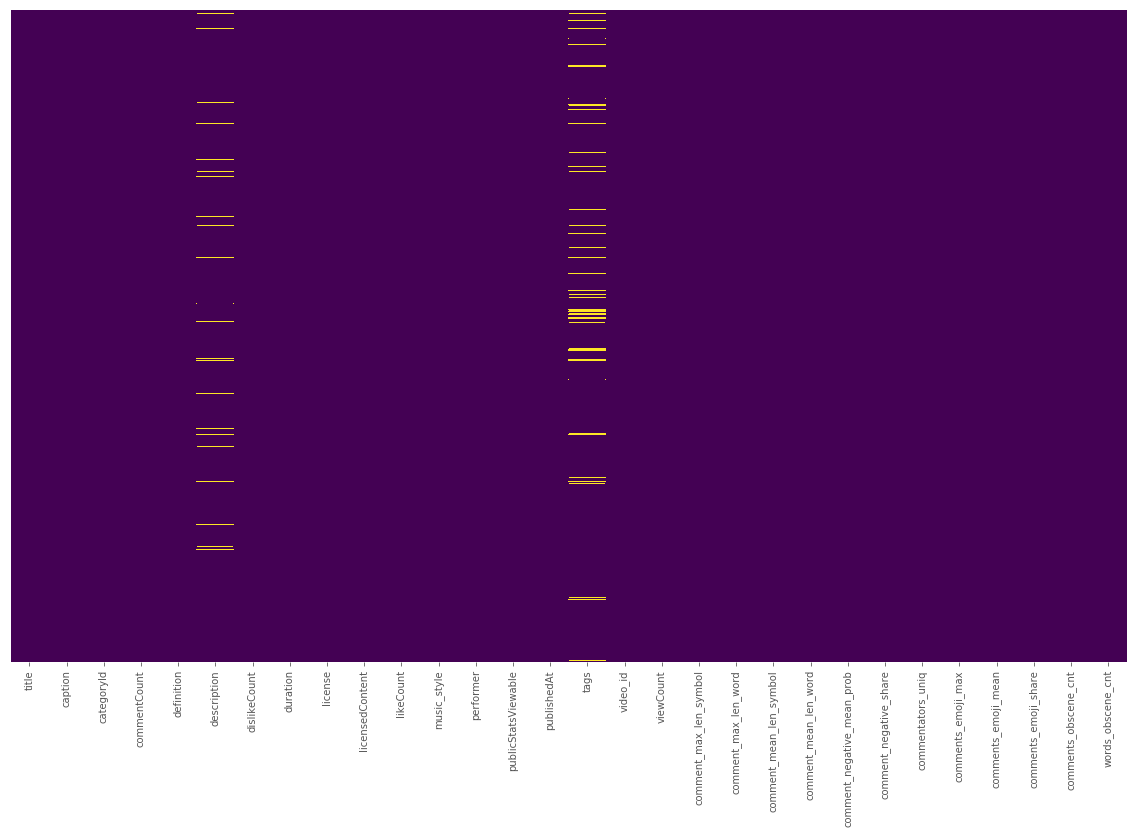

In [40]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# 2. Что будем предсказывать? 

Предсказывать будем жанр видео. Давайте посмотрим какие у нас есть жанры в данных. 

In [41]:
data.music_style.value_counts()

rock       5888
estrada    4151
popsa      3339
shanson    2061
rap        2028
indi       1359
classic     298
Name: music_style, dtype: int64

Разбиваем выборку на обучающую выборку, в которой мы будем находить закономерности, и тестовую выборку, на которой мы будем проверять выявленные закономерности.

In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state=201905)

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (15299, 30)
Размер тестовой выборки: (3825, 30)


Убедимся, что мы не нарушили пропорции жанров при делении выборки на тренировочную и тестову. __Как думаете, зачем это нужно?__ 

In [43]:
train.music_style.value_counts()/train.shape[0]

rock       0.308125
estrada    0.216093
popsa      0.177528
shanson    0.107393
rap        0.105040
indi       0.070789
classic    0.015034
Name: music_style, dtype: float64

In [44]:
test.music_style.value_counts()/test.shape[0]

rock       0.306928
estrada    0.220915
popsa      0.162876
rap        0.110065
shanson    0.109281
indi       0.072157
classic    0.017778
Name: music_style, dtype: float64

Вроде бы всё нормально. Сейчас в нашем датасете все жанры записаны в текстовом виде. Мы с вами постоянно повторяем, как прописную истину то, что __модели поедают только цифры.__ Давайте переработаем жанры в дамми-переменные. Для этого будем использовать one hot encoding.

In [65]:
# подгрузили команду для обработки 
from sklearn.preprocessing import OneHotEncoder

# объявили кодировщик (как с регрессией было, но кодировщик)
# опция нужна, чтобы видеть данные, которые придут к нам на выход
encoder = OneHotEncoder(sparse=False)

# обучили кодировщик (он запомнил какой цифрой закодирован какой стиль)
encoder.fit(train.music_style.get_values().reshape((len(train), 1)))

encoder.categories_  # можно посмотреть какие категории он выучил и какие позиции за них отвечают 

[array(['classic', 'estrada', 'indi', 'popsa', 'rap', 'rock', 'shanson'],
       dtype=object)]

In [67]:
# преобразуем наши выборки 
y_train = encoder.transform(train.music_style.get_values().reshape((len(train), 1)))
Y_test = encoder.transform(test.music_style.get_values().reshape((len(test), 1)))

# теперь у нас в y лежит куча столбцов, единичка только в одном из них
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
# это видео относится к какой категории? 
y_train[0]

array([0., 1., 0., 0., 0., 0., 0.])

# 3. Моделирование! 

Давайте строить прогнозные модели! 

## 3.1 k Nearest Neighbours (метод ближайших соседей) 

**KNN** - один из базовых и максимально наглядных алгоритмов. Среди уже известных нам объектов находятся $k$ максимально похожих на наш неизвестный объект (соседей). Неизвестному объекту проставляется тот класс, который наиболее широко представлен среди его соседей. 

Возьмем все числовые данные из нашего набора.

In [45]:
X_train = train[real_variables]
X_test = test[real_variables]

Внутри метода ближайшего соседа мы будем измерять похожесть между объектами с помощью какого-то расстояния. На примеры таких расстояний мы смотрели на паре по математике для анализа данных. 

Давайте посмотрим на слудущую проблему. Пусть у нас есть два человека: Вася и Петя. Вася весит $90$ кг. Петя $60$ кг. У Васи рост $1.9$ метра. У Пети $1.7$ метра. Посчитаем расстояние между парнями: 

$$
\rho(\text{Вася}, \text{Петя}) = \sqrt{(1.9 - 1.7)^2 + (90 - 60)^2} = \sqrt{0.04 + 900}. 
$$

Какой из признаков вносит больший вклад в расстояние? Рост. Просто из-за того, что он измерен в другой шкале. Это будет путать алгоритм, когда он будет искать расстояния. Чтобы избежать такой путанницы, данные нужно отскалировать. То есть привести к одной шкале. Например, с помощью `Min-max scaler`, который вы сами реализовывали в третьей домашке. После такого скалирования мы избавимся от зависимости от шкалы измерения. 

In [71]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Он сам будет считать максимумы, минимумы и делить! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы, поделил)
scaler.fit(X_train) 

# Теперь применяем его к нашим данным 
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

Наконец-то мы можем начать учить модели. Подгружаем метод ближайших соседей из пакета. 

In [73]:
from sklearn.neighbors import KNeighborsClassifier

# объявляем метод 9 ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 9)

# обучаем его по выборке 
knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_predicted = knn.predict(X_test_norm)

Сейчас наши прогнозы выглядя как страшная матрица из дамми-переменных. 

In [74]:
y_predicted

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Как превратить её обратно, в осмысленные жанры? Правильно! Вспомнить про `encoder`, который мы создали выше. 

In [75]:
y_predicted = encoder.inverse_transform(y_predicted)
y_predicted

array([['classic'],
       ['rock'],
       ['classic'],
       ...,
       ['classic'],
       ['classic'],
       ['classic']], dtype=object)

Интересно было бы узнать насколько качественной у нас получилась модель. Давайте посмотрим на какую-нибудь метрику качества, например на `accuracy`.  __Как думаете, это хорошая идея?__ 

In [77]:
from sklearn.metrics import accuracy_score

accuracy_score(test.music_style.values, y_predicted)

0.2169934640522876

Негусто. Возможно нам стоит попробовать по разному учитывать соседей: более близкие соседи должны давать больший вклад, чем удаленные. Для этого у метода есть опция `distance`. 

In [79]:
# снова объявили метод ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 9, weights='distance')

# обучили его 
knn.fit(X_train_norm, y_train)

# построили прогноз 
y_predicted = knn.predict(X_test_norm)

# раскодировали его 
y_predicted = encoder.inverse_transform(y_predicted)

# посчитали долю верных ответов
accuracy_score(test.music_style.values, y_predicted)

0.2593464052287582

Чуточку лучше. Для того, чтобы построить хорошую модель иногда нужно перебрать довольно много разных параметров модели. Давайте попробуем немного поперибирать. 

In [80]:
# Решётка для перебора 
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(5, 16),         # число соседей от 5 до 15
     'weights':['uniform', 'distance']   # надо ли более близких соседей учитывать с большим весом
             }

# объявили модель
knn = KNeighborsClassifier()

# завернули её в решётку для поиска параметров
grid = GridSearchCV(knn, parameters, cv=3, scoring="accuracy")

# Обратите внимание на аргументы решчетого поиска: 
#       1. Сначала модель
#       2. Какие параметры перебирать 
#       3. Число фолдов для кросс-валидации (подробнее с ней вы поработаете в домашке)
#       4. Метрика, по которой нужно считать качество модели 

# обучаем нашу решётку (если мы хотим перебрать много параметров, обучение будет идти долго) 
grid.fit(X_train_norm, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 16), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [82]:
# смотрим какие параметры дали наибольшее качество
print(grid.best_estimator_)

# а также смотрим на качество этого классификатора
print(grid.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')
0.278514935616707


Нам удалось поднять качество ещё сильнее! Ура. 

## 3.2 Решающие деревья 

<img src = "http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528907338/classification-tree_ygvats.png">

В листьях дерево - конечные принимаемые решения, в разветвлениях функции от отдельного признака. Давайте посмотрим как обучить дерево в питоне. 

In [83]:
# Подшружаем дерево 
from sklearn.tree import DecisionTreeClassifier

In [85]:
# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train, y_train)

# предсказываем на тестовой выборке результаты 
y_predicted = tree.predict(X_test)

# раскодировали предсказания 
y_predicted = encoder.inverse_transform(y_predicted)

# посмотрели на качество на тесте
accuracy_score(test.music_style.values, y_predicted)

0.3754248366013072

Дерево хорошо своей простотой, но по факту, чем выше наше дерево, тем более оно склонно к переобучению.
Как быть? Построить много невысоких деревьев. Много деревьев - это лес, алгоритм, принимающий решение на основе множества деревьев, так и называется.


In [87]:
# Подшружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев максимальной глубины 13 
forest = RandomForestClassifier(max_depth=13, n_estimators=1000)

# учим лес 
forest.fit(X_train, y_train)

# строим предсказания 
y_predicted = forest.predict(X_test)

# раскодировали их 
y_predicted = encoder.inverse_transform(y_predicted)

# посмотрели долю верных прогнозов
accuracy_score(test.music_style.values, y_predicted)

0.2415686274509804

# 4. Метрики классификации 

Отлично! У нас получилось оценить какой-то алгоритм. Давайте теперь посмотрим на то

# Feature Engineering
в реальной жизни очевидных признаков всегда не хватает. Тогда приходится самостоятельно придумывать и извлекать новые признаки из сырых данных. Попробуем что-то придумать 

первое на что можно обратить внимание столбец categoryId. в нем числовой идентификатор категории. Попробуем для начала преобразовать его используя OHE

In [ ]:
catEncoder = OneHotEncoder()
catEncoder.fit(train.categoryId.values.reshape((len(train), 1)))
cat_train = catEncoder.transform(train.categoryId.values.reshape((len(train), 1))).toarray()
cat_test = catEncoder.transform(test.categoryId.values.reshape((len(test), 1))).toarray()

кроме того мы можем использовать наиболее часто употребляемые теги

In [ ]:
from ast import literal_eval


In [ ]:
#для начала уберем пустые значения
train.tags = train.tags.apply(lambda tags: [] if pd.isnull(tags) else literal_eval(tags))
test.tags = test.tags.apply(lambda tags: [] if pd.isnull(tags) else literal_eval(tags))

In [ ]:
from collections import defaultdict

import operator

In [ ]:
tags_frequency = defaultdict(int)
for tags in train.tags:
    for tag in tags:
        tags_frequency[tag.lower()] += 1
tags_frequency = sorted(tags_frequency.items(), key=operator.itemgetter(1),reverse=True)


возьмем 50 наиболее популярных тегов, и бинаризуем их

In [ ]:
tag_index = {tag[0]: index for index, tag in enumerate(tags_frequency[:50])}

In [ ]:
def tagsToFeatures(tags):
    features = np.zeros(51)
    for tag in tags:
        index = tag_index.get(tag.lower(), -1)
        features[index] = 1
    return features[:50] 

In [ ]:
tags_train = train.tags.apply(tagsToFeatures)
tags_train = np.array(tags_train.to_list())
tags_test = test.tags.apply(tagsToFeatures)
tags_test = np.array(tags_test.to_list())

Теперь обучим новый лес

In [ ]:
X_train = np.hstack((X_train.values, cat_train, tags_train))
X_test = np.hstack((X_test.values, cat_test, tags_test))

In [ ]:
X_train.shape, X_test.shape

In [ ]:
forest = RandomForestClassifier(max_depth=13, n_estimators=5000)
forest.fit(X_train, Y_train)

In [ ]:
Y_predicted = forest.predict(X_test)
Y_predicted = encoder.inverse_transform(Y_predicted)
accuracy_score(test.music_style.values, Y_predicted)

Попробуйте перебрать параметры и добиться более высокой точности для леса

# 4. Схема нашей работы 

1. Посмотрели на данные, поняли что хотим прогнозировать 
2. Посмотрели есть ли в данных пропуски, обработали их (выбросили либо заполнили)
3. Проскалировали переменные 
4. Подготовили переменную для прогнозирования, посмотрели есть ли с ней проблемы 
5. Начали строить модели, смотрим насколько они хороши по метрикам 
6. Подбираем гиперпараметры для моделей и пытаемся улучшить их